In [1]:
import pandas as pd
import numpy as np
import requests
import bs4
from bs4 import BeautifulSoup
from tqdm import tqdm 
import time
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [2]:
df = pd.read_csv('indeed.csv')
df.head()

,Job Title,Company,Location,Salary,Rating,Job_Description,Urls,Date
0,newAssociate Data Scientist,NextEra Energy,"West Palm Beach, FL 33407+6 locations",Full-time,3.9,Employees in this role use knowledge of machi...,https://www.indeed.com/rc/clk?jk=c3fa211b2a472...,PostedToday
1,Data Scientist (Remote),Yelp,Remote,"$88,000 - $220,000 a year",3.4,"Communicate key insights from analyses, exper...",https://www.indeed.com/rc/clk?jk=0072004f2d318...,Posted30+ days ago
2,newData Scientist,Fidelity Investments,"Boston, MA 02210 (South Boston area)+5 locations",Full-time,4.0,Experience with some of the following areas: ...,https://www.indeed.com/rc/clk?jk=a3af122c4dd4a...,PostedJust posted
3,newData Scientist 1,Pacific Northwest National Laboratory,"Remote in Seattle, WA 98109+1 location",Full-time,4.0,Practical knowledge in different machine lear...,https://www.indeed.com/rc/clk?jk=39a9f24ce28f6...,Posted2 days ago
4,Data Scientist,Aaron's,Remote,Full-time,NaN,"Performs duties related to data mining, machi...",https://www.indeed.com/company/Radancy_Atlanta...,Posted17 days ago


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Job Title        1500 non-null   object 
 1   Company          1500 non-null   object 
 2   Location         1500 non-null   object 
 3   Salary           1430 non-null   object 
 4   Rating           1209 non-null   float64
 5   Job_Description  1500 non-null   object 
 6   Urls             1500 non-null   object 
 7   Date             1500 non-null   object 
dtypes: float64(1), object(7)
memory usage: 93.9+ KB


In [4]:
df=df.drop_duplicates()


In [5]:
df.Location.value_counts()

Remote                                                  6
Spokane, WA+19 locations                                3
Montgomery County, MD                                   3
West Palm Beach, FL 33407+6 locations                   2
Arlington, VA+6 locations                               2
                                                       ..
Arlington, VA+8 locations                               1
Juno Beach, FL 33408+6 locations                        1
Remote in Dearborn, MI+4 locations                      1
Remote in New York, NY+10 locations                     1
Chicago, IL 60611 (Near North Side area)+3 locations    1
Name: Location, Length: 63, dtype: int64

In [6]:
df.Salary.isna().sum()

15

In [7]:
df['Salary'].dropna(inplace=True)

In [8]:
df.Salary.value_counts()

Full-time                     40
$125,000 - $225,000 a year     5
$88,000 - $220,000 a year      3
Internship                     3
$75,000 - $150,000 a year      3
$126,233 - $164,102 a year     3
$6,999 - $9,583 a month        2
Temporary +1                   2
$90,000 - $135,000 a year      2
$115,638 a year                2
$112,187 - $173,922 a year     2
$90 - $120 an hour             2
$90,000 - $110,000 a year      1
$36.49 - $62.52 an hour        1
$15 - $35 an hour              1
$120,000 - $130,000 a year     1
Name: Salary, dtype: int64

In [9]:
df = df[df.Salary.str.contains('year').fillna(False)] 
df_sin_salario = df[df.Salary.str.contains('year') == False] 

In [10]:
from string import digits
numerals = digits + '-' + ','

In [11]:
df.Salary = df.Salary.apply(lambda x : ''.join(c for c in x if c in numerals))


In [12]:
df.Salary = df.Salary.str.replace(',','').str.replace('+','').str.split('-', expand=True).astype(float).mean(axis=1)

/var/folders/bj/ndgdqzgj6qgd9y613qph_m180000gn/T/ipykernel_21015/1876774673.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.Salary = df.Salary.str.replace(',','').str.replace('+','').str.split('-', expand=True).astype(float).mean(axis=1)


In [13]:
df['Salary_HI_or_LOWER']=df.Salary.apply(lambda x : 1 if x > df.Salary.median() else 0)


In [14]:
df['Salary_HI_or_LOWER'].value_counts(normalize=True)


1    0.5
0    0.5
Name: Salary_HI_or_LOWER, dtype: float64

In [15]:
df.head()

,Job Title,Company,Location,Salary,Rating,Job_Description,Urls,Date,Salary_HI_or_LOWER
1,Data Scientist (Remote),Yelp,Remote,154000.0,3.4,"Communicate key insights from analyses, exper...",https://www.indeed.com/rc/clk?jk=0072004f2d318...,Posted30+ days ago,1
5,newData Scientist,Comcentric,"Spokane, WA+19 locations",175000.0,4.2,Strong math/statistics/probability/data model...,https://www.indeed.com/rc/clk?jk=a29410df7af36...,Posted1 day ago,1
8,new(Junior / Senior) Data Scientist - Sports A...,Zelus Analytics,"Remote in Austin, TX",112500.0,NaN,Provide guidance and technical mentorship for...,https://www.indeed.com/rc/clk?jk=f0dc7447a2cd9...,Posted4 days ago,0
10,newInterdisciplinary Health Scientist (Data Sc...,US National Institutes of Health,"Montgomery County, MD",145167.5,4.3,You must be a U.S. Citizen or U.S. National.,https://www.indeed.com/rc/clk?jk=071c621311435...,Posted4 days ago,1
53,Data Scientist (Junior),BDSA,"Remote in Louisville, CO",100000.0,NaN,"For example, combining public weather data wi...",https://www.indeed.com/rc/clk?jk=c1e2abfc99160...,Posted30+ days ago,0


/Users/joacosoulez/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


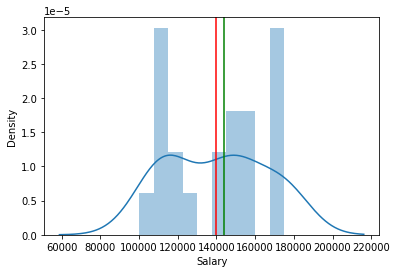

In [16]:
import seaborn as sns
ax = sns.distplot(df['Salary'], bins=10)
ax.axvline(df['Salary'].mean(), c='r')
ax.axvline(df['Salary'].median(), c='g')

In [17]:
twentieth = df['Salary'].quantile(0.20)
eightyfifth = df['Salary'].quantile(0.85)
mean = round(df['Salary'].mean(),2)
min = df['Salary'].min()

In [18]:
def percentile_cls(row):
    
    salary = row['Salary']    
    if salary < twentieth:
        return 'between '+ str(min) + ' and ' + str(twentieth)
    elif salary >= twentieth and salary < mean:
        return 'between '+ str(twentieth) + ' and ' + str(mean) 
    elif salary >= mean and salary < eightyfifth:
        return 'between '+ str(mean) + ' and ' + str(eightyfifth)
    else:
      return 'more than '+ str(eightyfifth)

In [19]:
df['salary_class'] = df.apply(percentile_cls, axis=1)

In [20]:
prueba = df[['salary_class','Salary']]
prueba.head(12)

,salary_class,Salary
1,between 139881.25 and 175000.0,154000.0
5,more than 175000.0,175000.0
8,between 112500.0 and 139881.25,112500.0
10,between 139881.25 and 175000.0,145167.5
53,between 100000.0 and 112500.0,100000.0
58,between 112500.0 and 139881.25,112500.0
95,more than 175000.0,175000.0
98,between 112500.0 and 139881.25,112500.0
194,between 112500.0 and 139881.25,115638.0
256,between 139881.25 and 175000.0,154000.0


In [21]:
import re

def find_skills(url):
    skills = ['C','C++','Java','Javascript','Python','R','SQL','Hadoop','Hive','Pig','Spark','AWS','Tableau']
  
    for s in skills:
        df[s] = 0
  
  #Calculating the occurence of each skill
    for index, row in df.iterrows():

      match1 = re.findall(r'\b[Pp]ython|python\b', row['Job_Description']) 
      if len(match1) > 0:
          df.at[index, 'Python'] = 1
      else:
         df.at[index, 'Python'] = 0

      match2 = re.findall(r'\bC\b', row['Job_Description']) 
      if len(match2) > 0:
          df.at[index, 'C'] = 1
      else:
        df.at[index, 'C'] = 0
      match3 = re.findall(r'\bC\+\+\b', row['Job_Description']) 
      if len(match3) > 0:
          df.at[index, 'C++'] = 1
      else:
        df.at[index, 'C++'] = 0

      match4 = re.findall(r'\b[Jj]ava|JAVA\b', row['Job_Description']) 
      if len(match4) > 0:
          df.at[index, 'Java'] = 1
      else:
        df.at[index, 'Java'] = 0
      match5 = re.findall(r'\b[Jj]avascript|JAVASCRIPT\b', row['Job_Description']) 
      if len(match5) > 0:
          df.at[index, 'Javascript'] = 1
      else:
        df.at[index, 'Javascript'] = 0
      match6 = re.findall(r'\bR\b', row['Job_Description']) 
      if len(match6) > 0:
          df.at[index, 'R'] = 1
      else:
        df.at[index, 'R'] = 0
      match7 = re.findall(r'\b[sS]ql|SQL\b', row['Job_Description']) 
      if len(match7) > 0:
        df.at[index, 'SQL'] = 1
      else:
        df.at[index, 'SQL'] = 0
      match8 = re.findall(r'\b[Hh]adoop|HADOOP\b', row['Job_Description']) 
      if len(match8) > 0:
          df.at[index, 'Hadoop'] = 1
      else:
        df.at[index, 'Hadoop'] = 0
      match9 = re.findall(r'\b[hH]ive|HIVE\b', row['Job_Description']) 
      if len(match9) > 0:
          df.at[index, 'Hive'] = 1
      else:
        df.at[index, 'Hive'] = 0
      match10 = re.findall(r'\b[Pp]ig|PIG\b', row['Job_Description']) 
      if len(match10) > 0:
          df.at[index, 'Pig'] = 1
      else:
        df.at[index, 'Pig'] = 0
      match11 = re.findall(r'\b[Ss]park|SPARK\b', row['Job_Description']) 
      if len(match11) > 0:
          df.at[index, 'Spark'] = 1
      else:
        df.at[index, 'Spark'] = 0
      match12 = re.findall(r'\b[Aa]ws|AWS\b', row['Job_Description']) 
      if len(match12) > 0:
          df.at[index, 'AWS'] = 1
      else:
        df.at[index, 'AWS'] = 0
      match13 = re.findall(r'\b[tT]ableau|ABLEAU\b', row['Job_Description']) 
      if len(match13) > 0:
          df.at[index, 'Tableau'] = 1
      else:
        df.at[index, 'Tableau'] = 0


    return df

In [22]:
df.head()

,Job Title,Company,Location,Salary,Rating,Job_Description,Urls,Date,Salary_HI_or_LOWER,salary_class
1,Data Scientist (Remote),Yelp,Remote,154000.0,3.4,"Communicate key insights from analyses, exper...",https://www.indeed.com/rc/clk?jk=0072004f2d318...,Posted30+ days ago,1,between 139881.25 and 175000.0
5,newData Scientist,Comcentric,"Spokane, WA+19 locations",175000.0,4.2,Strong math/statistics/probability/data model...,https://www.indeed.com/rc/clk?jk=a29410df7af36...,Posted1 day ago,1,more than 175000.0
8,new(Junior / Senior) Data Scientist - Sports A...,Zelus Analytics,"Remote in Austin, TX",112500.0,NaN,Provide guidance and technical mentorship for...,https://www.indeed.com/rc/clk?jk=f0dc7447a2cd9...,Posted4 days ago,0,between 112500.0 and 139881.25
10,newInterdisciplinary Health Scientist (Data Sc...,US National Institutes of Health,"Montgomery County, MD",145167.5,4.3,You must be a U.S. Citizen or U.S. National.,https://www.indeed.com/rc/clk?jk=071c621311435...,Posted4 days ago,1,between 139881.25 and 175000.0
53,Data Scientist (Junior),BDSA,"Remote in Louisville, CO",100000.0,NaN,"For example, combining public weather data wi...",https://www.indeed.com/rc/clk?jk=c1e2abfc99160...,Posted30+ days ago,0,between 100000.0 and 112500.0


In [23]:
df = df.dropna()

In [24]:
#   summary = {'Python': round(sum(df["Python"]/len(df))*100, 2),
#            'C': round(sum(df["C"]/len(df))*100, 2),
#            'Cplus2': round(sum(df["C++"]/len(df))*100, 2),
#            'Java': round(sum(df["Java"]/len(df))*100, 2),
#            'Javascript':round(sum(df["Javascript"]/len(df))*100, 2),
#            'R':round(sum(df["R"]/len(df))*100, 2),
#            'SQL':round(sum(df["SQL"]/len(df))*100, 2),
#            'Hadoop':round(sum(df["Hadoop"]/len(df))*100, 2),
#            'Hive':round(sum(df["Hive"]/len(df))*100, 2),
#            'Pig':round(sum(df["Pig"]/len(df))*100, 2),
#            'Spark':round(sum(df["Spark"]/len(df))*100, 2),
#            'AWS':round(sum(df["AWS"]/len(df))*100, 2),
#            'Tableau':round(sum(df["Tableau"]/len(df))*100, 2),
#           }


In [25]:
# summaryy = pd.DataFrame(summary,index=[0])

In [26]:
# Summary = summaryy.T
# Summary['Porcentaje'] = Summary[0]
# Summary = Summary.drop(columns = [0])
# # Summary

In [27]:
# import matplotlib.pyplot as plt

# labels = summary.keys()
# sizes = summary.values()

# fig1, ax1 = plt.subplots(figsize=(7, 7))
# ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
# ax1.axis('equal') 

# # plt.show()

In [28]:
!pip install wordcloud
from wordcloud import WordCloud


You should consider upgrading via the '/Users/joacosoulez/.pyenv/versions/3.8.12/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


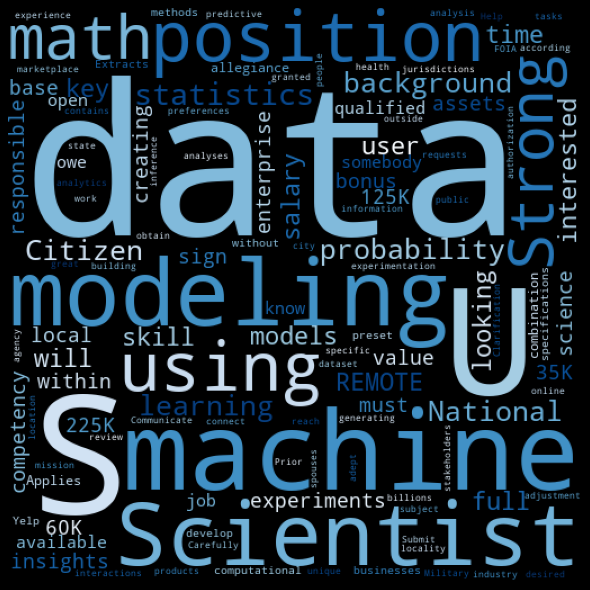

In [29]:
import matplotlib.pyplot as plt
palabras_repetidas = ' '.join(list(map(str, df['Job_Description'])))
palabras_repetidas2 = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(palabras_repetidas)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(palabras_repetidas2)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [30]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joacosoulez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joacosoulez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joacosoulez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
def stop_words_and_lemmatizer(text):
  stopwords = nltk.corpus.stopwords.words('english')
  stopwords.append('a')
  stopwords.append('yes')
  stopwords.append('be')
  stopwords.append('and')
  stopwords.append('to')
  stopwords.append('of')
  stopwords.append('with')
  stopwords.append('in')
  stopwords.append('the')
  stopwords.append('work')
  stopwords.append('for')
  # stopwords.append('experience')
  stopwords.append('working')
  stopwords.append('using')
  stopwords.append('end')


  stop_words = set(stopwords)
  
  word_tokens = nltk.word_tokenize(text) 
  
  without_stopwords = [w for w in word_tokens if not w in stop_words]
  
  lemmatizer = WordNetLemmatizer()
  
  lemmatized = [lemmatizer.lemmatize(word) for word in without_stopwords]
  
  return lemmatized

In [32]:
def to_lower(text):
    return text.lower()

In [33]:
def remove_numbers(text):
    """ Remove numbers """
    words_only = ''.join([w for w in text if not w.isdigit()])
    return words_only

In [34]:
def remove_bad_symbols(text):
    """Remove unwanted symbols from text"""
    bad_symbols = re.compile('[^0-9a-z #+_]')
    return bad_symbols.sub(' ', text)

In [35]:
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')  
    return text

In [36]:
from nltk.text import TextCollection
def clean_text(text):
    """ Return a preprocessed sequence of texts """
    return text.apply(
        remove_bad_symbols).apply(
        remove_punctuation).apply(
        remove_numbers).apply(
        to_lower).apply(stop_words_and_lemmatizer)

In [37]:
job_desc = df['Job_Description'].to_list()

In [38]:
import string 
from nltk.stem import WordNetLemmatizer

for n in range(len(job_desc)):
  job_desc[n] = to_lower(str(job_desc[n]))
  job_desc[n] = remove_bad_symbols(str(job_desc[n]))
  job_desc[n] = remove_punctuation(str(job_desc[n]))
#   job_desc[n] = remove_numbers(str(job_desc[n]))
  job_desc[n] = stop_words_and_lemmatizer(str(job_desc[n]))

In [39]:
from collections import Counter, defaultdict
total_counts = Counter()
for line in job_desc:
  for palabra in line:
    words = palabra.split()
    for word in words:
      total_counts[word] += 1

print("Total words in data set: ", len(total_counts))



Total words in data set:  118


In [40]:
vocab = sorted(total_counts, key=total_counts.get, reverse=True)[:500]
print(vocab[:30])

['data', 'u', 'machine', 'modeling', 'scientist', 'position', 'strong', 'math', 'statistic', 'probability', 'background', 'citizen', 'national', 'learning', 'key', 'looking', 'remote', 'full', 'time', 'model', 'user', 'salary', 'interested', 'skill', 'insight', 'analysis', 'experiment', '35k', '60k', 'sign']


In [41]:
total_counts.most_common(10)

[('data', 17),
 ('u', 8),
 ('machine', 5),
 ('modeling', 5),
 ('scientist', 5),
 ('position', 5),
 ('strong', 4),
 ('math', 4),
 ('statistic', 4),
 ('probability', 4)]

In [42]:
word2idx = {}
for i, word in enumerate(vocab):
    word2idx[word] = i

In [43]:
def text_to_vector(text):
  word_vec = np.zeros((1, len(vocab)))
  for texto in job_desc:
    for frase in texto:
      a = frase.split()
      for word in a:
        if word in word2idx.keys():
          word_vec[0][word2idx[word]] += 1
          
  return np.array(word_vec)

In [44]:
word_vectors = np.zeros((len(job_desc), len(vocab)), dtype=np.int_)
for ii, text in enumerate(job_desc):
    word_vectors[ii] = text_to_vector(text)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


X = word_vectors
Y = df['Salary_HI_or_LOWER'].values


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

class Rf:
  def __init__(self):
    self.classifier = RandomForestClassifier()
  
  def fitModel(self, X, Y):
    self.classifier.fit(X, Y)
  
  def predictModel(self, X):
    return self.classifier.predict(X)
  
  def scoreModel(self, X, Y):
    return self.classifier.score(X, Y)

class SVM:
  def __init__(self, kernel = "rbf"):
    self.classifier = SVC(kernel = kernel, random_state = 0)
  
  def fitModel(self, X, Y):
    self.classifier.fit(X, Y)
  
  def predictModel(self, X):
    return self.classifier.predict(X)
  
  def scoreModel(self, X, Y):
    return self.classifier.score(X, Y)

print("Random forest: ")
rfModel = Rf()
rfModel.fitModel(X, Y)
Y_pred1 = rfModel.predictModel(X_test)
print(classification_report(Y_test,Y_pred1))

print("SVM: ")
svmModel = SVM()
svmModel.fitModel(X, Y)
Y_pred2 = svmModel.predictModel(X_test)
print(classification_report(Y_test, Y_pred2))